# KNN WITH COLOR **HISTOGRAM**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pickle
from collections import Counter

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [ ]:
import zipfile


zip_path = "ZIP_cropped_objectsV3.zip"     # Change this to your actual zip file name
extract_dir = "dataset"           # Where to extract your files

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
dataset_path = "dataset"

# Create paths for each split (train, validation, test)
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")

# Display the paths to verify they're correct
print("Dataset paths configured:")
print(f"  Train: {train_path}")
print(f"  Valid: {valid_path}")
print(f"  Test: {test_path}")


Dataset paths configured:
  Train: dataset/train
  Valid: dataset/valid
  Test: dataset/test


# a small satatic  to better undestand the data

In [ ]:
class_names = sorted(os.listdir(train_path))
print(f" Found {len(class_names)} classes: {class_names}")

# Count how many images are in each class
print("\nDataset Statistics (Training Set):")
print("-" * 40)
for class_name in class_names:
    class_folder = os.path.join(train_path, class_name)

    # Count image files (jpg, jpeg, png formats)
    image_files = [f for f in os.listdir(class_folder)
                   if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    num_images = len(image_files)

    print(f"  {class_name}: {num_images} images")
print("-" * 40)

✓ Found 7 classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']

Dataset Statistics (Training Set):
----------------------------------------
  bicycles: 46 images
  buses: 88 images
  crosswalks: 157 images
  fire hydrants: 60 images
  motorcycles: 158 images
  traffic lights: 459 images
  vehicles: 763 images
----------------------------------------


# Load all train/valid/test images and show some examples

In [ ]:
def load_images_from_folder(base_path, class_names):

    images = []
    labels = []

    # Loop through each class folder
    for class_name in class_names:
        class_folder = os.path.join(base_path, class_name)

        # Get all image files in this class folder
        image_files = [f for f in os.listdir(class_folder)
                      if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        # Load each image
        for img_file in image_files:
            img_path = os.path.join(class_folder, img_file)

            # Read image using OpenCV (reads in BGR color format)
            img = cv2.imread(img_path)

            # Only add if image loaded successfully
            if img is not None:
                images.append(img)
                labels.append(class_name)

    return images, labels

print("✓ Image loading function defined!")
print("This function will read all images and organize them with their labels.")

✓ Image loading function defined!
This function will read all images and organize them with their labels.


In [ ]:
# Load training images and labels
print("⏳ Loading training images...")
train_images, train_labels = load_images_from_folder(train_path, class_names)
print(f"✓ Loaded {len(train_images)} training images")

# Load validation images and labels
print("\n⏳ Loading validation images...")
valid_images, valid_labels = load_images_from_folder(valid_path, class_names)
print(f"✓ Loaded {len(valid_images)} validation images")

# Load test images and labels
print("\n⏳ Loading test images...")
test_images, test_labels = load_images_from_folder(test_path, class_names)
print(f"✓ Loaded {len(test_images)} test images")

# Summary
print("\n" + "="*50)
print("DATASET LOADING COMPLETE!")
print("="*50)
print(f"Total images loaded: {len(train_images) + len(valid_images) + len(test_images)}")
print(f"  - Training: {len(train_images)}")
print(f"  - Validation: {len(valid_images)}")
print(f"  - Test: {len(test_images)}")
print("="*50)

⏳ Loading training images...
✓ Loaded 1731 training images

⏳ Loading validation images...
✓ Loaded 798 validation images

⏳ Loading test images...
✓ Loaded 506 test images

DATASET LOADING COMPLETE!
Total images loaded: 3035
  - Training: 1731
  - Validation: 798
  - Test: 506


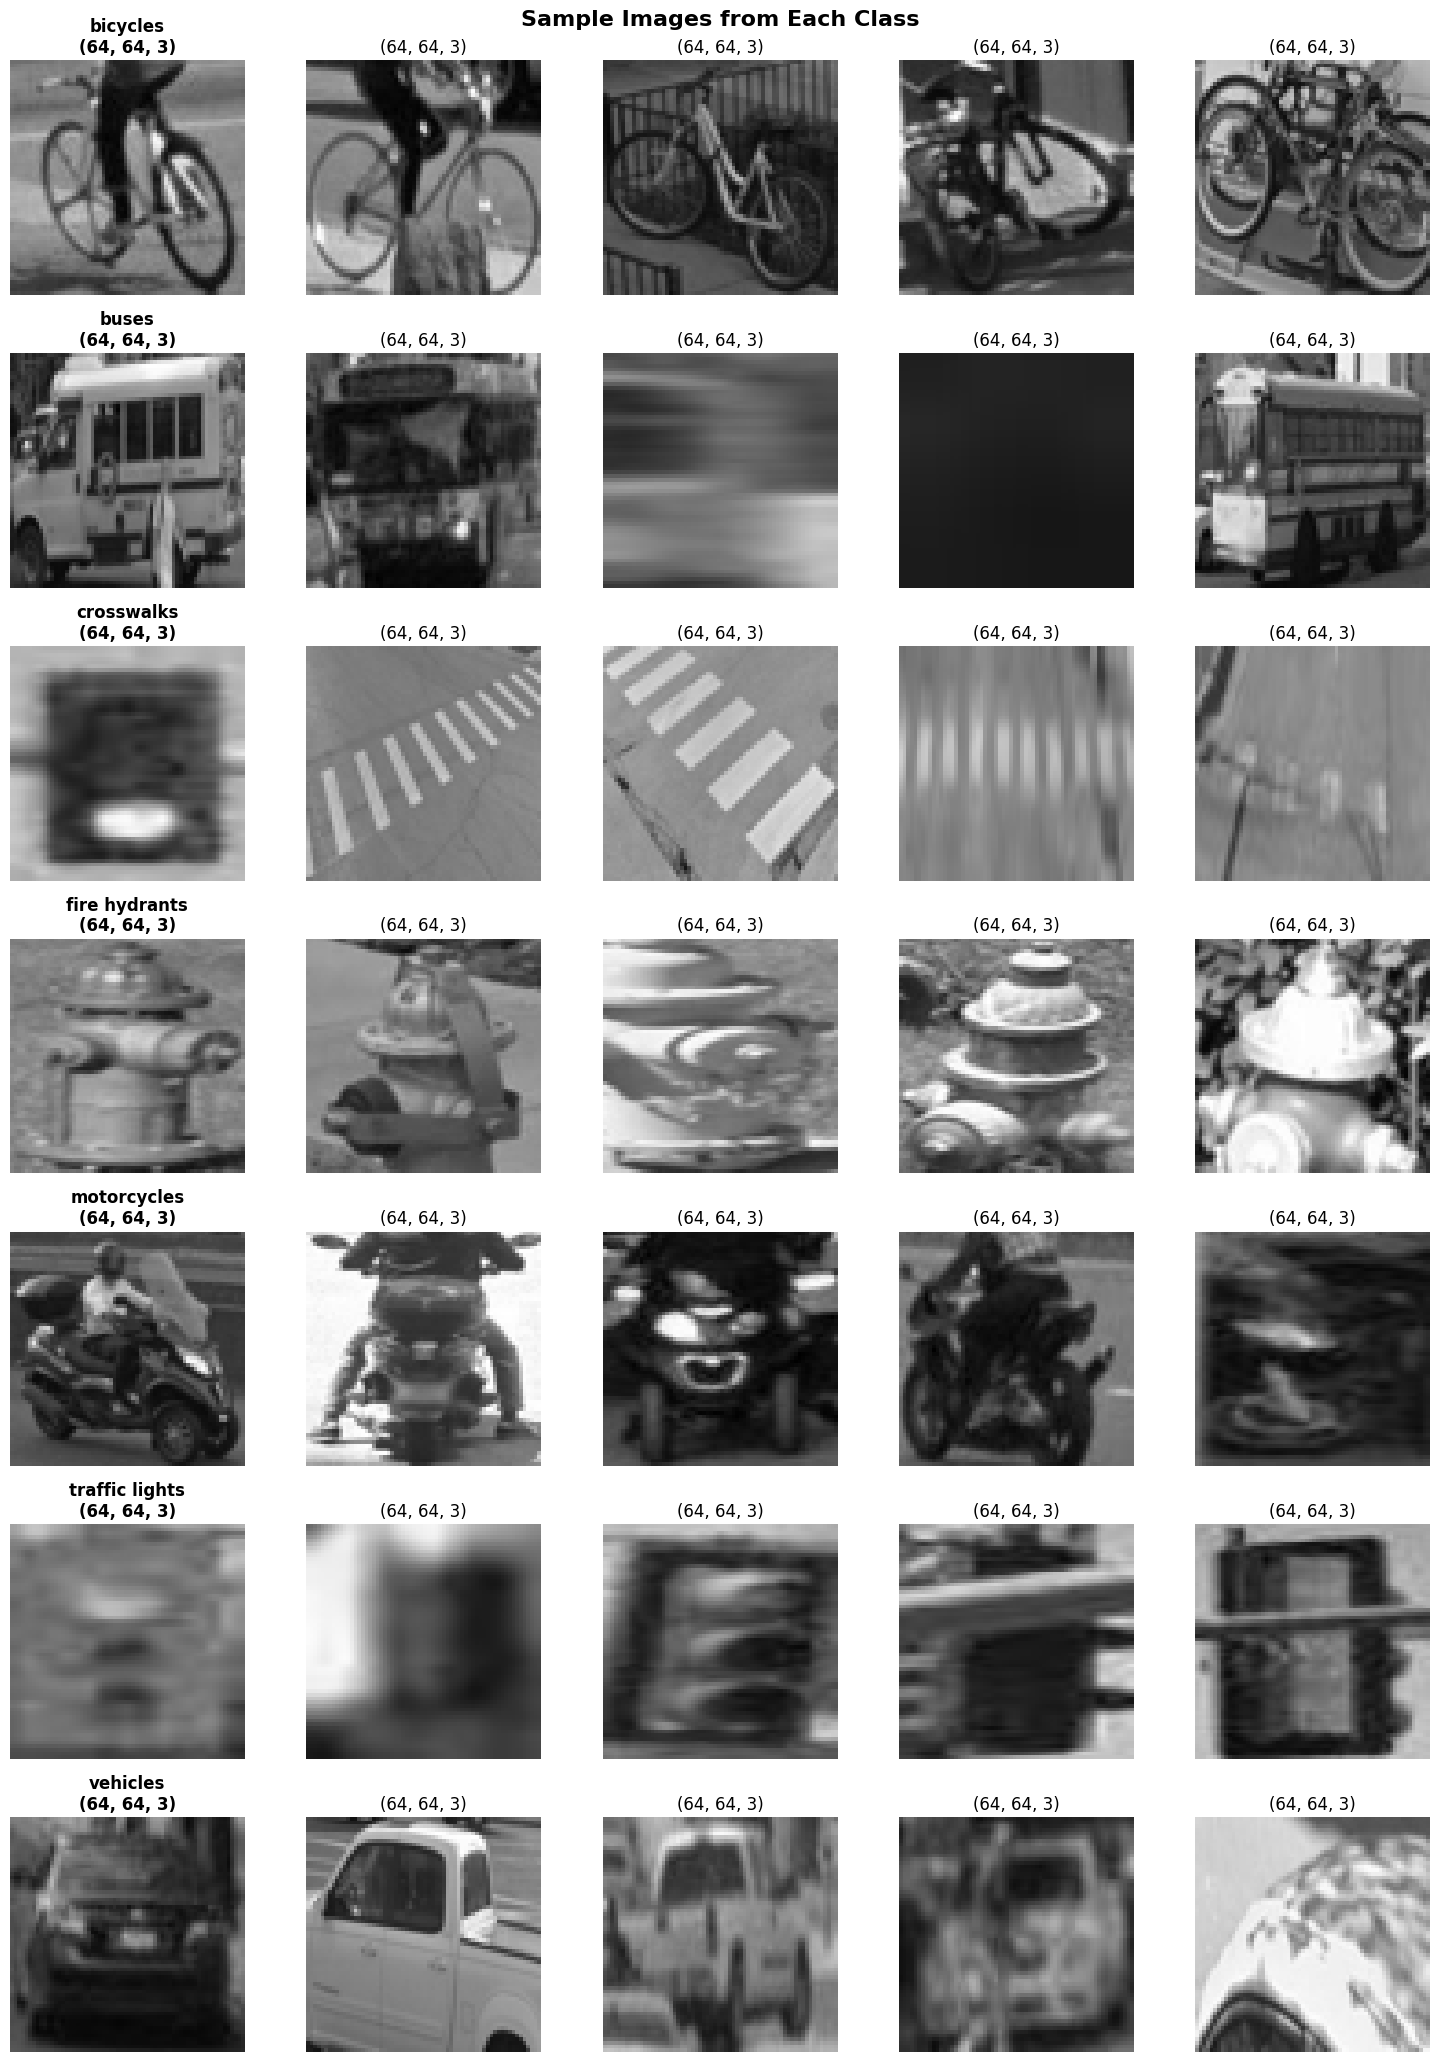

✓ Visualization complete!


In [ ]:


# Create a grid: one row per class, 5 columns for samples
fig, axes = plt.subplots(len(class_names), 5, figsize=(15, 3*len(class_names)))
fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')

# Loop through each class
for i, class_name in enumerate(class_names):
    # Get indices of all images belonging to this class
    class_indices = [idx for idx, label in enumerate(train_labels) if label == class_name]

    # Display up to 5 sample images from this class
    for j in range(min(5, len(class_indices))):
        idx = class_indices[j]
        img = train_images[idx]

        # Convert BGR (OpenCV format) to RGB (matplotlib format) for correct colors
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Handle single class vs multiple classes
        ax = axes[i, j] if len(class_names) > 1 else axes[j]

        # Display the image
        ax.imshow(img_rgb)
        ax.axis('off')  # Remove axes for cleaner look

        # Add title with class name and image dimensions
        if j == 0:
            ax.set_title(f'{class_name}\n{img.shape}', fontweight='bold')
        else:
            ax.set_title(f'{img.shape}')

plt.tight_layout()
plt.show()

print("✓ Visualization complete!")

# Create color histogram feature extraction function and extracte the features


** How it works:**

*    1. Split image into 3 color channels: Blue, Green, Red
* 2. For each channel, count pixels in each intensity range (bins)
* 3. Normalize the counts to get proportions
* 4. Combine all histograms into one feature vector


** Why 32 bins?**
 - Balance between detail and efficiency
 - Each channel: 256 intensity levels → 32 bins (groups of 8)
 - Total features: 32 bins × 3 channels = 96 features



# Grayscale histogram explained (since our images are gray scaled)
**How it works**
- Single channel: grayscale images have one intensity channel instead of three.
- Bin counts: count how many pixels fall into each intensity bin (0–255 divided into bins ranges).
- Normalize: divide counts by the total number of pixels so the vector sums to 1.
- Feature vector: the histogram itself is the feature vector — length equals bins.

**Why choose bins**
- Same tradeoff as color: more bins → more detail, higher dimensionality; fewer bins → more robustness and speed.
- If you used 32 bins per color channel before, use 32 bins for grayscale for comparable resolution.
- Total features for grayscale = bins (e.g., 32), not 96.


In [ ]:
import cv2
import numpy as np

def extract_gray_histogram(image, bins=32):
    """
    Extract a normalized grayscale histogram feature vector from an image.
    - If the input is color (H,W,3) it is converted to grayscale first.
    - Returns a 1D numpy array of length `bins`.
    """
    # If image has 3 channels, convert to grayscale
    if image.ndim == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Compute histogram for the single channel
    hist = cv2.calcHist([gray], [0], None, [bins], [0, 256]).astype(np.float32)

    # Normalize to sum to 1 (L1 normalization)
    hist /= (hist.sum() + 1e-9)

    # Flatten to 1D feature vector
    features = hist.flatten()
    return features

# --- Test the function on a sample image ---
print("🔍 Testing grayscale feature extraction on a sample image...")
sample_img = train_images[0]   # keep your existing variable
sample_features = extract_gray_histogram(sample_img, bins=32)

print("✓ Feature extraction successful!")
print(f"  Input: Image shape = {sample_img.shape}")
print(f"  Output: Feature vector shape = {sample_features.shape}")
print(f"  Calculation: 1 channel × 32 bins = {sample_features.shape[0]} features")

🔍 Testing grayscale feature extraction on a sample image...
✓ Feature extraction successful!
  Input: Image shape = (64, 64, 3)
  Output: Feature vector shape = (32,)
  Calculation: 1 channel × 32 bins = 32 features


**visualization for the  histogram color**

📊 Creating grayscale histogram visualization...


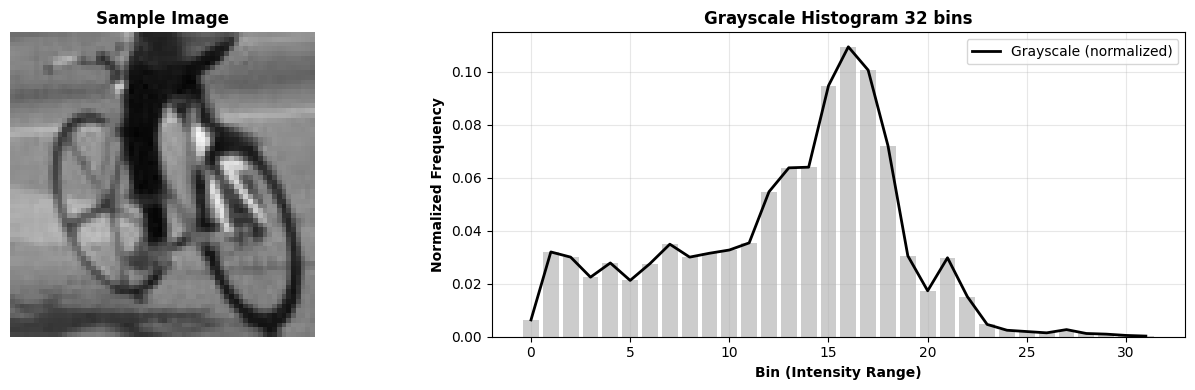

✓ Visualization complete!

Interpretation:
- Peaks show which intensity ranges are most common in the image
- Grayscale histograms capture brightness/texture information without color
- Use these histograms as features for KNN when color is not available


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("📊 Creating grayscale histogram visualization...")

# Assume sample_img is your BGR image (as in your code)
# Convert BGR -> RGB for display and BGR -> GRAY for histogram
sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
sample_img_gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# LEFT PLOT Show the image in RGB
axes[0].imshow(sample_img_rgb)
axes[0].set_title('Sample Image', fontweight='bold', fontsize=12)
axes[0].axis('off')

# RIGHT PLOT Show the grayscale histogram
bins = 32
hist_gray = cv2.calcHist([sample_img_gray], [0], None, [bins], [0, 256]).flatten()
# Normalize for nicer plotting (optional)
hist_gray_norm = hist_gray / (hist_gray.sum() + 1e-9)

# Plot histogram as a line and as bars for clarity
bin_edges = np.arange(bins)
axes[1].plot(bin_edges, hist_gray_norm, color='black', linewidth=2, label='Grayscale (normalized)')
axes[1].bar(bin_edges, hist_gray_norm, color='gray', alpha=0.4)

# Styling
axes[1].set_title('Grayscale Histogram 32 bins', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Bin (Intensity Range)', fontweight='bold')
axes[1].set_ylabel('Normalized Frequency', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete!")
print("\nInterpretation:")
print("- Peaks show which intensity ranges are most common in the image")
print("- Grayscale histograms capture brightness/texture information without color")
print("- Use these histograms as features for KNN when color is not available")

# extracting features

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Grayscale histogram extractor (safe for both grayscale and 3-channel images) ---
def extract_gray_histogram(image, bins=32):
    """
    Input: image as numpy array (H,W) or (H,W,3) in BGR or grayscale.
    Output: 1D numpy array length = bins, normalized to sum to 1.
    """
    # If image has 3 channels, convert to grayscale
    if image.ndim == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Compute histogram and normalize (L1)
    hist = cv2.calcHist([gray], [0], None, [bins], [0, 256]).astype(np.float32)
    hist /= (hist.sum() + 1e-9)
    return hist.flatten()

# --- Optional quick check to see what your images look like ---
print("🔎 Quick image shape check (first 5 training images):")
for i, img in enumerate(train_images[:5]):
    print(f"  [{i}] shape: {img.shape}, ndim: {img.ndim}")
print("If shapes are (H, W) they are single-channel grayscale.")
print("If shapes are (H, W, 3) they are 3-channel images (may still be visually gray).")
print()

# --- Feature extraction using grayscale histograms ---
bins = 32
print("⏳ Extracting grayscale histogram features from all images...")
print("This may take a few moments...\n")

# ===== TRAINING SET =====
print("📦 Processing training images...")
X_train = []
for img in train_images:
    features = extract_gray_histogram(img, bins=bins)
    X_train.append(features)

X_train = np.array(X_train)
y_train = np.array(train_labels)

print(f"  ✓ X_train shape: {X_train.shape}")
print(f"    → {X_train.shape[0]} images, {X_train.shape[1]} features each")
print(f"  ✓ y_train shape: {y_train.shape}")

# ===== VALIDATION SET =====
print("\n📦 Processing validation images...")
X_valid = []
for img in valid_images:
    features = extract_gray_histogram(img, bins=bins)
    X_valid.append(features)

X_valid = np.array(X_valid)
y_valid = np.array(valid_labels)

print(f"  ✓ X_valid shape: {X_valid.shape}")
print(f"    → {X_valid.shape[0]} images, {X_valid.shape[1]} features each")
print(f"  ✓ y_valid shape: {y_valid.shape}")

# ===== TEST SET =====
print("\n📦 Processing test images...")
X_test = []
for img in test_images:
    features = extract_gray_histogram(img, bins=bins)
    X_test.append(features)

X_test = np.array(X_test)
y_test = np.array(test_labels)

print(f"  ✓ X_test shape: {X_test.shape}")
print(f"    → {X_test.shape[0]} images, {X_test.shape[1]} features each")
print(f"  ✓ y_test shape: {y_test.shape}")

# Summary
print("\n" + "="*60)
print("FEATURE EXTRACTION COMPLETE!")
print("="*60)
print("All images have been converted to grayscale histogram vectors.")
print(f"Each vector length = {bins} (because bins = {bins}).")
print("Ready for training! 🚀")
print("="*60)

🔎 Quick image shape check (first 5 training images):
  [0] shape: (64, 64, 3), ndim: 3
  [1] shape: (64, 64, 3), ndim: 3
  [2] shape: (64, 64, 3), ndim: 3
  [3] shape: (64, 64, 3), ndim: 3
  [4] shape: (64, 64, 3), ndim: 3
If shapes are (H, W) they are single-channel grayscale.
If shapes are (H, W, 3) they are 3-channel images (may still be visually gray).

⏳ Extracting grayscale histogram features from all images...
This may take a few moments...

📦 Processing training images...
  ✓ X_train shape: (1731, 32)
    → 1731 images, 32 features each
  ✓ y_train shape: (1731,)

📦 Processing validation images...
  ✓ X_valid shape: (798, 32)
    → 798 images, 32 features each
  ✓ y_valid shape: (798,)

📦 Processing test images...
  ✓ X_test shape: (506, 32)
    → 506 images, 32 features each
  ✓ y_test shape: (506,)

FEATURE EXTRACTION COMPLETE!
All images have been converted to grayscale histogram vectors.
Each vector length = 32 (because bins = 32).
Ready for training! 🚀


# trainning the KNN model and evaluate it on the valid set

In [ ]:
print(" Training K-Nearest Neighbors (KNN) model...")
print()

# Define K value here we just pick a k value and we will check the best k (that guves the best acc after ) when we do the hyperamter
k_value = 5

# Create the KNN classifier
knn_model = KNeighborsClassifier(
    n_neighbors=k_value,        # Use 5 nearest neighbors
    metric='euclidean',          # Measure distance using Euclidean distance
    weights='uniform'            # All neighbors vote equally
)

# Train the model
# Note: KNN doesn't actually "train" - it just stores the data!
knn_model.fit(X_train, y_train)

print(f"✓ KNN model trained successfully!")
print(f"\nModel Configuration:")
print(f"  - Number of neighbors (k): {k_value}")
print(f"  - Distance metric: Euclidean")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Number of classes: {len(class_names)}")
print(f"  - Classes: {class_names}")
print()
print("The model is now ready to make predictions! 🎯")

 Training K-Nearest Neighbors (KNN) model...

✓ KNN model trained successfully!

Model Configuration:
  - Number of neighbors (k): 5
  - Distance metric: Euclidean
  - Training samples: 1731
  - Number of classes: 7
  - Classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']

The model is now ready to make predictions! 🎯


In [ ]:
print("⏳ Making predictions...")
y_valid_pred = knn_model.predict(X_valid)
print("✓ Predictions complete!")

# Calculate overall accuracy
valid_accuracy = accuracy_score(y_valid, y_valid_pred)

print()
print("="*60)
print("VALIDATION RESULTS")
print("="*60)
print(f"Overall Accuracy: {valid_accuracy*100:.2f}%")
print(f"Correct Predictions: {int(valid_accuracy * len(y_valid))}/{len(y_valid)}")
print("="*60)

# Detailed classification report
print("\n📊 Detailed Classification Report:")
print("-"*60)
print(classification_report(y_valid, y_valid_pred))

# Explanation of metrics
print("\nMetrics Explanation:")
print("  • Precision: When model predicts a class, how often is it right?")
print("  • Recall: Of all actual examples, how many did the model find?")
print("  • F1-score: Harmonic mean of precision and recall")
print("  • Support: Number of actual examples of each class")

⏳ Making predictions...
✓ Predictions complete!

VALIDATION RESULTS
Overall Accuracy: 57.14%
Correct Predictions: 456/798

📊 Detailed Classification Report:
------------------------------------------------------------
                precision    recall  f1-score   support

      bicycles       0.00      0.00      0.00        14
         buses       0.07      0.09      0.08        11
    crosswalks       0.80      0.72      0.76        46
 fire hydrants       0.00      0.00      0.00        11
   motorcycles       0.23      0.42      0.30        52
traffic lights       0.74      0.51      0.60       364
      vehicles       0.56      0.71      0.63       300

      accuracy                           0.57       798
     macro avg       0.34      0.35      0.34       798
  weighted avg       0.61      0.57      0.58       798


Metrics Explanation:
  • Precision: When model predicts a class, how often is it right?
  • Recall: Of all actual examples, how many did the model find?
  • F1-sc

# hyperamter the model using the gridsearch methode

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_)

# Extract k values and mean test scores
k_values = grid.cv_results_['param_n_neighbors'].data
accuracies = grid.cv_results_['mean_test_score']

# Find the best k and accuracy
best_k = grid.best_params_['n_neighbors']
best_acc = grid.best_score_


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py", line 446, in score
    return super().score(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 572, in score
    return accuracy_score(y, self.predict(X), sample_weig

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_classification.py", line 446, in score
    return super().score(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 572, in score
    return accuracy_score(y, self.predict(X), sample_weig

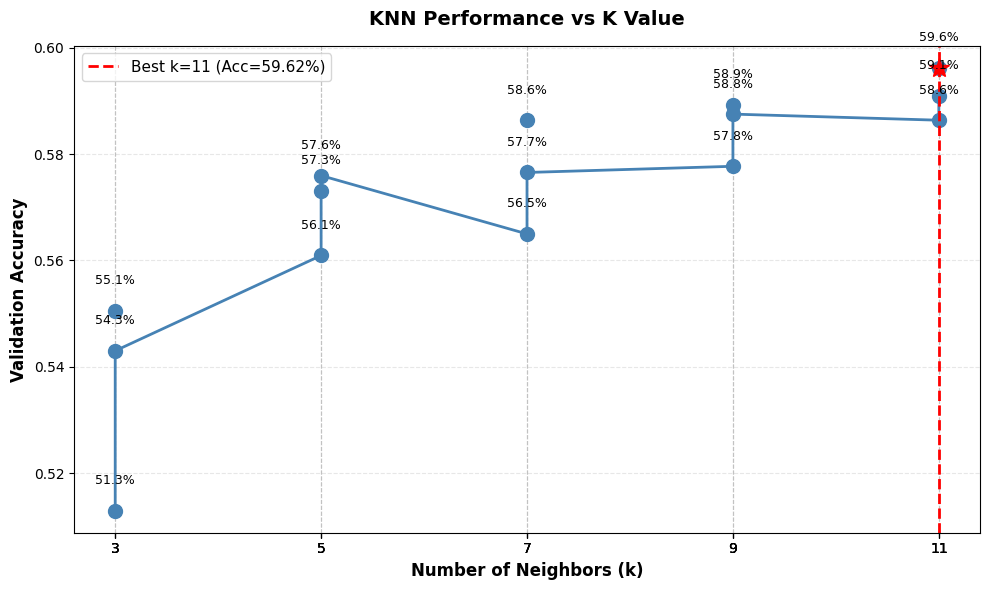


✓ Optimal k value identified!


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linewidth=2, markersize=10, color='steelblue')
plt.xlabel('Number of Neighbors (k)', fontweight='bold', fontsize=12)
plt.ylabel('Validation Accuracy', fontweight='bold', fontsize=12)
plt.title('KNN Performance by the K Value', fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(k_values)

# Mark the best k value with a red line
plt.axvline(x=best_k, color='red', linestyle='--', linewidth=2,
            label=f'Best k={best_k} (Acc={best_acc*100:.2f}%)')

# Highlight the best point with a red star
plt.plot(best_k, best_acc, marker='*', markersize=15, color='red')

# Add percentage labels on each point
for k, acc in zip(k_values, accuracies):
    plt.text(k, acc + 0.005, f'{acc*100:.1f}%', ha='center', fontsize=9)

plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

print("\n✓ Optimal k value identified!")

# train the best model with both the train and the valid sets

In [ ]:
import numpy as np

print(f"🎯 Training final KNN model with optimal k={best_k} using TRAIN+VALID sets...")
print()

# Combine training and validation sets
X_full = np.concatenate([X_train, X_valid], axis=0)
y_full = np.concatenate([y_train, y_valid], axis=0)

# Create the final KNN classifier with the best k value
final_knn_model = KNeighborsClassifier(
    n_neighbors=best_k,
    metric='euclidean',
    weights='uniform'
)

# Train on the combined dataset
final_knn_model.fit(X_full, y_full)

print("✓ Final model trained successfully on TRAIN+VALID data!")
print()
print("="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"  Model Type: K-Nearest Neighbors (KNN)")
print(f"  Optimal K: {best_k} neighbors")
print(f"  Training+Validation samples: {len(X_full)}")
print(f"  Features per sample: {X_full.shape[1]}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Classes: {class_names}")
print(f"  Expected validation accuracy (from CV): {best_acc*100:.2f}%")
print("="*60)
print()
print("The final model is ready for testing! 🚀")

🎯 Training final KNN model with optimal k=11 using TRAIN+VALID sets...

✓ Final model trained successfully on TRAIN+VALID data!

FINAL MODEL SUMMARY
  Model Type: K-Nearest Neighbors (KNN)
  Optimal K: 11 neighbors
  Training+Validation samples: 2529
  Features per sample: 32
  Number of classes: 7
  Classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']
  Expected validation accuracy (from CV): 59.62%

The final model is ready for testing! 🚀


# eveluate in the test set

In [ ]:
print("📊 Final evaluation on test set...")
print("This is the moment of truth! 🎯\n")

# Make predictions on test set
print("⏳ Making predictions on test images...")
y_test_pred = final_knn_model.predict(X_test)
print("✓ Predictions complete!\n")

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Display results
print("="*60)
print("🏆 FINAL TEST RESULTS")
print("="*60)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Correct Predictions: {int(test_accuracy * len(y_test))}/{len(y_test)}")
print(f"Incorrect Predictions: {len(y_test) - int(test_accuracy * len(y_test))}/{len(y_test)}")
print("="*60)

# Compare with validation accuracy
print(f"\nComparison:")
print(f"  Validation Accuracy: {best_acc*100:.2f}%")
print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
difference = test_accuracy - best_acc
if abs(difference) < 0.02:
    print(f"  ✓ Performance is consistent! (Difference: {abs(difference)*100:.2f}%)")
elif test_accuracy < best_acc:
    print(f"  ⚠ Test accuracy is {abs(difference)*100:.2f}% lower (possible overfitting)")
else:
    print(f"  ✓ Test accuracy is {difference*100:.2f}% higher (great!)")

# Detailed classification report for test set
print("\n📊 Detailed Test Classification Report:")
print("-"*60)
print(classification_report(y_test, y_test_pred))

print("\nThis is your model's real-world performance! 🎉")

📊 Final evaluation on test set...
This is the moment of truth! 🎯

⏳ Making predictions on test images...
✓ Predictions complete!

🏆 FINAL TEST RESULTS
Test Accuracy: 57.11%
Correct Predictions: 289/506
Incorrect Predictions: 217/506

Comparison:
  Validation Accuracy: 59.62%
  Test Accuracy: 57.11%
  ⚠ Test accuracy is 2.50% lower (possible overfitting)

📊 Detailed Test Classification Report:
------------------------------------------------------------
                precision    recall  f1-score   support

      bicycles       0.00      0.00      0.00        22
         buses       0.00      0.00      0.00        12
    crosswalks       0.90      0.68      0.77        81
 fire hydrants       0.00      0.00      0.00        23
   motorcycles       0.22      0.20      0.21        30
traffic lights       0.54      0.47      0.50       129
      vehicles       0.55      0.80      0.65       209

      accuracy                           0.57       506
     macro avg       0.32      0.31  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


📊 Creating confusion matrix for test set...


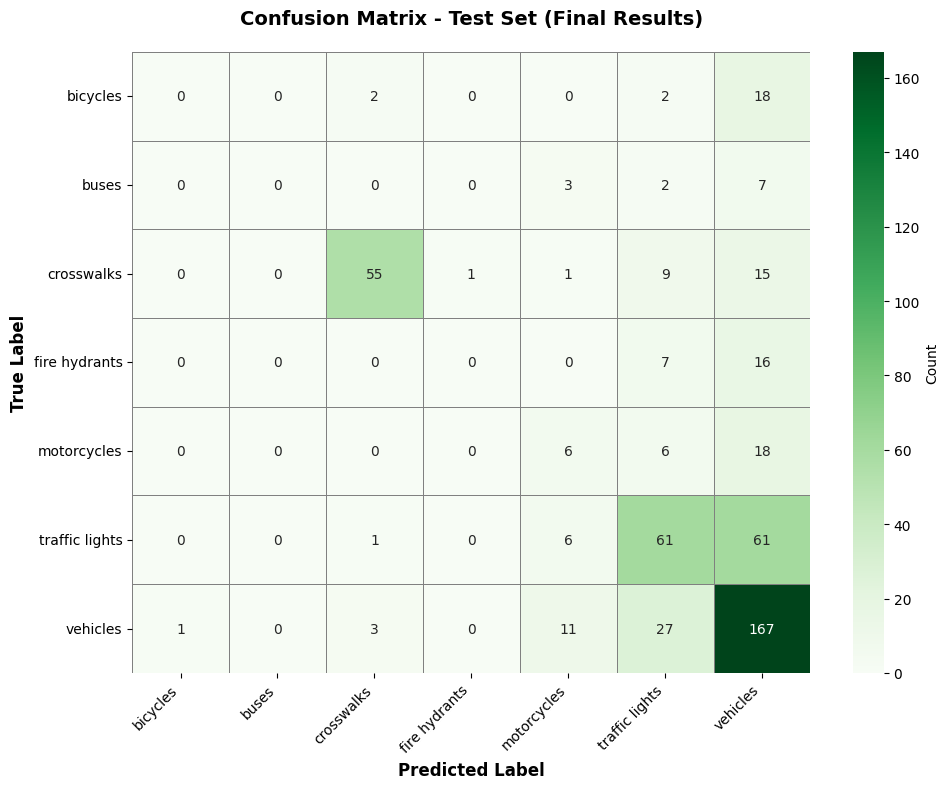


✓ Confusion matrix displayed!

📈 Analysis:
  bicycles: 0.0% (0/22 correct)
  buses: 0.0% (0/12 correct)
  crosswalks: 67.9% (55/81 correct)
  fire hydrants: 0.0% (0/23 correct)
  motorcycles: 20.0% (6/30 correct)
  traffic lights: 47.3% (61/129 correct)
  vehicles: 79.9% (167/209 correct)

Look for the darkest cells to see where predictions are strongest!


In [ ]:
print("📊 Creating confusion matrix for test set...")

# Compute confusion matrix for test predictions
cm_test = confusion_matrix(y_test, y_test_pred, labels=class_names)

# Create visualization
plt.figure(figsize=(10, 8))

# Use green color scheme for final results
sns.heatmap(
    cm_test,
    annot=True,                  # Show numbers
    fmt='d',                     # Integer format
    cmap='Greens',               # Green color palette
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)

# Add title and labels
plt.title('Confusion Matrix - Test Set (Final Results)',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontweight='bold', fontsize=12)
plt.xlabel('Predicted Label', fontweight='bold', fontsize=12)

# Rotate labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Analyze the confusion matrix
print("\n✓ Confusion matrix displayed!")
print("\n📈 Analysis:")

# Calculate per-class accuracy from confusion matrix
for i, class_name in enumerate(class_names):
    total_true = cm_test[i, :].sum()  # Total actual examples of this class
    correct = cm_test[i, i]            # Correctly predicted

    if total_true > 0:
        class_acc = (correct / total_true) * 100
        print(f"  {class_name}: {class_acc:.1f}% ({correct}/{total_true} correct)")

print("\nLook for the darkest cells to see where predictions are strongest!")

# **Prediction Visualization  and pre-class accurancy anlyze**

🖼️ Creating prediction visualization...
Showing correct and incorrect predictions...



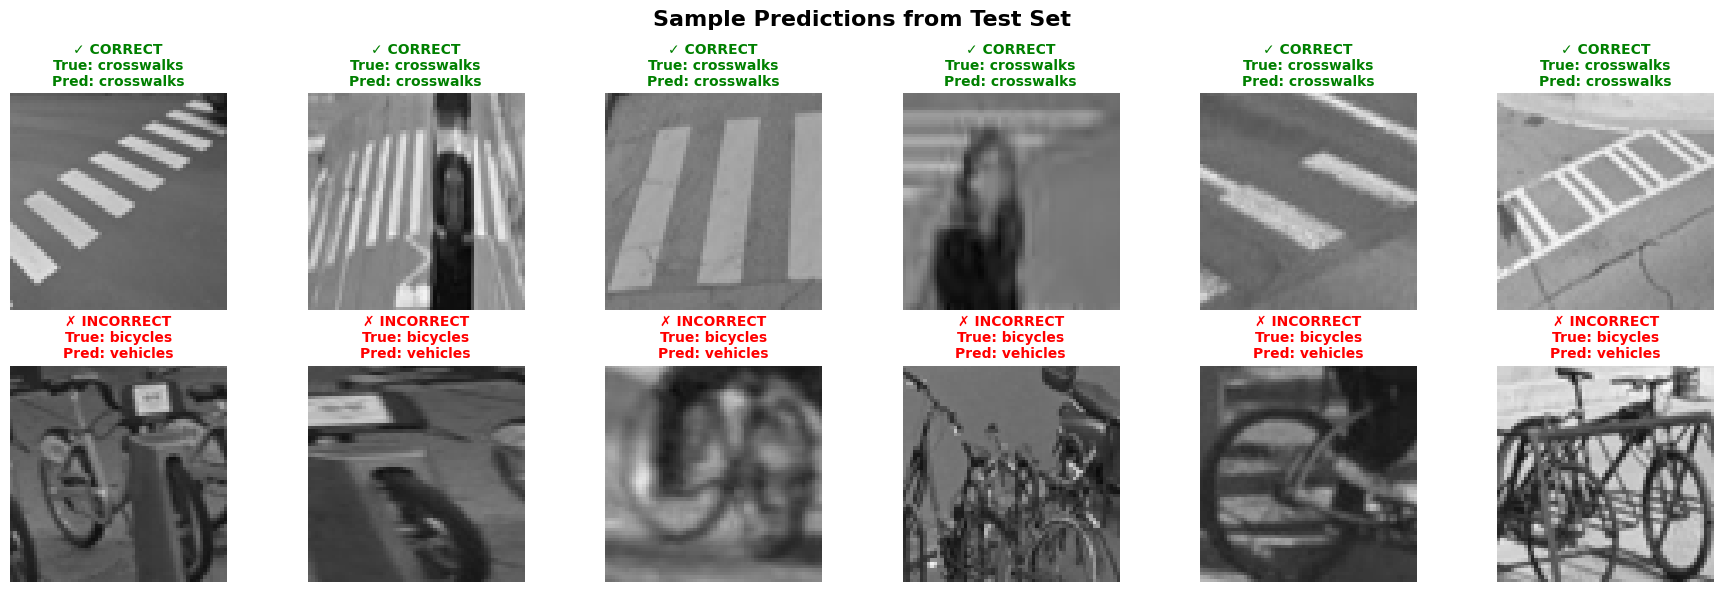

✓ Visualization complete!

Tips:
  • Compare correct vs incorrect predictions
  • Do the mistakes make sense?
  • Are some classes visually similar?


In [ ]:
print("🖼️ Creating prediction visualization...")
print("Showing correct and incorrect predictions...\n")

# Number of samples to show
num_samples = 6

# Create figure with 2 rows
fig, axes = plt.subplots(2, num_samples, figsize=(18, 6))
fig.suptitle('Sample Predictions from Test Set', fontsize=16, fontweight='bold')

# ===== TOP ROW: CORRECT PREDICTIONS =====
correct_indices = [i for i in range(len(y_test)) if y_test[i] == y_test_pred[i]]

if len(correct_indices) > 0:
    for i in range(min(num_samples, len(correct_indices))):
        idx = correct_indices[i]
        img = test_images[idx]

        # Convert BGR to RGB for display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display image
        axes[0, i].imshow(img_rgb)
        axes[0, i].set_title(
            f'✓ CORRECT\nTrue: {y_test[idx]}\nPred: {y_test_pred[idx]}',
            color='green',
            fontweight='bold',
            fontsize=10
        )
        axes[0, i].axis('off')
else:
    print("No correct predictions found (this shouldn't happen!)")

# ===== BOTTOM ROW: INCORRECT PREDICTIONS =====
incorrect_indices = [i for i in range(len(y_test)) if y_test[i] != y_test_pred[i]]

if len(incorrect_indices) > 0:
    for i in range(min(num_samples, len(incorrect_indices))):
        idx = incorrect_indices[i]
        img = test_images[idx]

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display image
        axes[1, i].imshow(img_rgb)
        axes[1, i].set_title(
            f'✗ INCORRECT\nTrue: {y_test[idx]}\nPred: {y_test_pred[idx]}',
            color='red',
            fontweight='bold',
            fontsize=10
        )
        axes[1, i].axis('off')
else:
    print("No incorrect predictions! Perfect score! 🎉")
    # Hide bottom row if no mistakes
    for i in range(num_samples):
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("✓ Visualization complete!")
print("\nTips:")
print("  • Compare correct vs incorrect predictions")
print("  • Do the mistakes make sense?")
print("  • Are some classes visually similar?")

📊 Analyzing per-class accuracy...

  bicycles            :   0.0% (  0/ 22 correct)
  buses               :   0.0% (  0/ 12 correct)
  crosswalks          :  67.9% ( 55/ 81 correct)
  fire hydrants       :   0.0% (  0/ 23 correct)
  motorcycles         :  20.0% (  6/ 30 correct)
  traffic lights      :  47.3% ( 61/129 correct)
  vehicles            :  79.9% (167/209 correct)



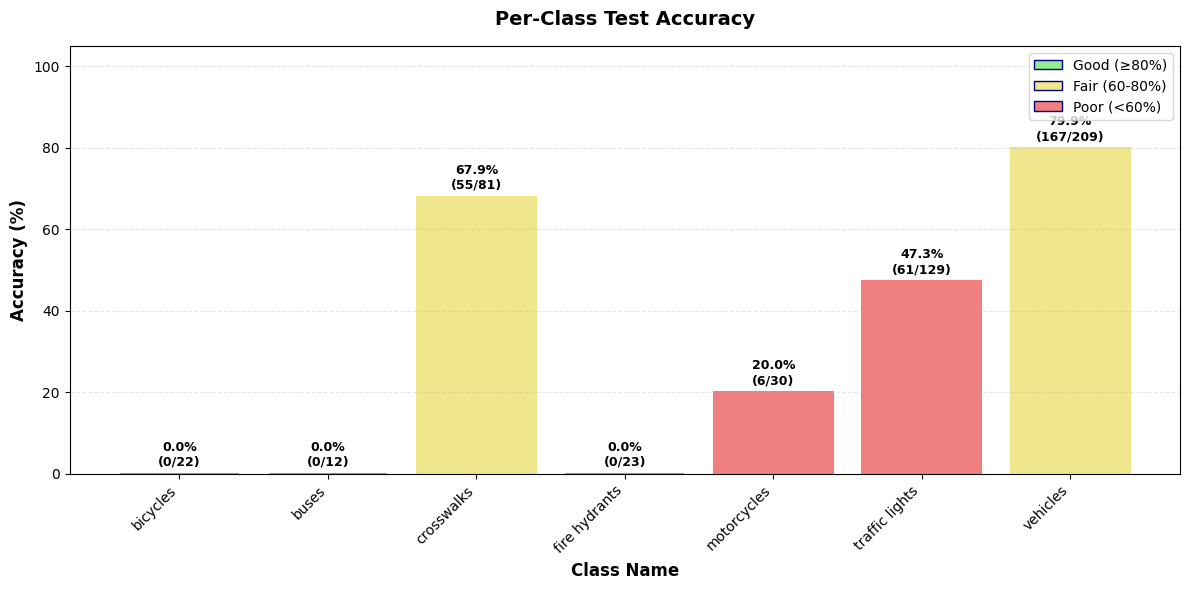


✓ Per-class analysis complete!

Insights:
  • Green bars: Classes the model handles well
  • Red bars: Classes that need attention
  • Consider collecting more data for poorly performing classes


In [ ]:
print("📊 Analyzing per-class accuracy...")
print()

# Calculate accuracy for each class
class_accuracies = {}
class_details = {}

for class_name in class_names:
    # Find all test examples of this class
    class_indices = [i for i in range(len(y_test)) if y_test[i] == class_name]

    if len(class_indices) > 0:
        # Count correct predictions
        class_correct = sum([1 for i in class_indices if y_test[i] == y_test_pred[i]])
        class_total = len(class_indices)
        class_acc = class_correct / class_total

        # Store results
        class_accuracies[class_name] = class_acc
        class_details[class_name] = (class_correct, class_total)

        # Print details
        print(f"  {class_name:20s}: {class_acc*100:5.1f}% ({class_correct:3d}/{class_total:3d} correct)")

print()

# Visualize per-class accuracy as a bar chart
plt.figure(figsize=(12, 6))

# Create bars
bars = plt.bar(
    class_accuracies.keys(),
    [acc*100 for acc in class_accuracies.values()],
    color='skyblue',
    edgecolor='navy',
    linewidth=1.5
)

# Color code bars: Green if >80%, Yellow if 60-80%, Red if <60%
for i, (class_name, acc) in enumerate(class_accuracies.items()):
    if acc >= 0.8:
        bars[i].set_color('lightgreen')
    elif acc >= 0.6:
        bars[i].set_color('khaki')
    else:
        bars[i].set_color('lightcoral')

# Add labels
plt.xlabel('Class Name', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
plt.title('Per-Class Test Accuracy', fontsize=14, fontweight='bold', pad=15)
plt.ylim([0, 105])
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, (class_name, acc) in enumerate(class_accuracies.items()):
    correct, total = class_details[class_name]
    plt.text(i, acc*100 + 2, f'{acc*100:.1f}%\n({correct}/{total})',
             ha='center', fontweight='bold', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='navy', label='Good (≥80%)'),
    Patch(facecolor='khaki', edgecolor='navy', label='Fair (60-80%)'),
    Patch(facecolor='lightcoral', edgecolor='navy', label='Poor (<60%)')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print("\n✓ Per-class analysis complete!")
print("\nInsights:")
print("  • Green bars: Classes the model handles well")
print("  • Red bars: Classes that need attention")
print("  • Consider collecting more data for poorly performing classes")